In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 o7ee3ga8


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-o7ee3ga8:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.6


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_ftr = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_ftr = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_ftr = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_ftr = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_ftr = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_ftr.extend(ftr.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_ftr.extend(ftr.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_ftr.extend(ftr.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_ftr.extend(ftr.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_ftr.extend(ftr.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                                                                     | 0/5867 [00:00<?, ?it/s]

  0%|                                                                                                                                                                           | 1/5867 [00:00<1:00:20,  1.62it/s]

  0%|▎                                                                                                                                                                           | 10/5867 [00:00<05:24, 18.03it/s]

  0%|▌                                                                                                                                                                           | 20/5867 [00:00<02:47, 34.94it/s]

  1%|▉                                                                                                                                                                           | 30/5867 [00:00<01:57, 49.59it/s]

  1%|█▏                                                                                                                                                                          | 40/5867 [00:01<01:35, 61.30it/s]

  1%|█▍                                                                                                                                                                          | 50/5867 [00:01<01:22, 70.87it/s]

  1%|█▊                                                                                                                                                                          | 60/5867 [00:01<01:14, 78.16it/s]

  1%|██                                                                                                                                                                          | 70/5867 [00:01<01:09, 83.50it/s]

  1%|██▎                                                                                                                                                                         | 80/5867 [00:01<01:06, 87.24it/s]

  2%|██▋                                                                                                                                                                         | 90/5867 [00:01<01:04, 90.05it/s]

  2%|██▉                                                                                                                                                                        | 100/5867 [00:01<01:02, 92.07it/s]

  2%|███▏                                                                                                                                                                       | 110/5867 [00:01<01:01, 93.61it/s]

  2%|███▍                                                                                                                                                                       | 120/5867 [00:01<01:00, 94.36it/s]

  2%|███▊                                                                                                                                                                       | 130/5867 [00:01<01:00, 95.10it/s]

  2%|████                                                                                                                                                                       | 140/5867 [00:02<00:59, 95.75it/s]

  3%|████▎                                                                                                                                                                      | 150/5867 [00:02<00:59, 96.15it/s]

  3%|████▋                                                                                                                                                                      | 160/5867 [00:02<00:59, 96.30it/s]

  3%|████▉                                                                                                                                                                      | 170/5867 [00:02<00:59, 96.44it/s]

  3%|█████▏                                                                                                                                                                     | 180/5867 [00:02<00:58, 96.75it/s]

  3%|█████▌                                                                                                                                                                     | 190/5867 [00:02<00:58, 96.70it/s]

  3%|█████▊                                                                                                                                                                     | 200/5867 [00:02<00:58, 96.58it/s]

  4%|██████                                                                                                                                                                     | 210/5867 [00:02<00:58, 96.63it/s]

  4%|██████▍                                                                                                                                                                    | 220/5867 [00:02<00:58, 96.89it/s]

  4%|██████▋                                                                                                                                                                    | 230/5867 [00:02<00:58, 96.91it/s]

  4%|██████▉                                                                                                                                                                    | 240/5867 [00:03<00:58, 96.82it/s]

  4%|███████▎                                                                                                                                                                   | 250/5867 [00:03<00:58, 96.68it/s]

  4%|███████▌                                                                                                                                                                   | 260/5867 [00:03<00:57, 96.73it/s]

  5%|███████▊                                                                                                                                                                   | 270/5867 [00:03<00:57, 96.84it/s]

  5%|████████▏                                                                                                                                                                  | 280/5867 [00:03<00:57, 97.07it/s]

  5%|████████▍                                                                                                                                                                  | 290/5867 [00:03<00:57, 96.95it/s]

  5%|████████▋                                                                                                                                                                  | 300/5867 [00:03<00:57, 96.95it/s]

  5%|█████████                                                                                                                                                                  | 310/5867 [00:03<00:57, 96.78it/s]

  5%|█████████▎                                                                                                                                                                 | 320/5867 [00:03<00:57, 96.45it/s]

  6%|█████████▌                                                                                                                                                                 | 330/5867 [00:04<00:58, 94.48it/s]

  6%|█████████▉                                                                                                                                                                 | 340/5867 [00:04<00:59, 93.26it/s]

  6%|██████████▏                                                                                                                                                                | 350/5867 [00:04<00:59, 92.48it/s]

  6%|██████████▍                                                                                                                                                                | 360/5867 [00:04<00:59, 91.92it/s]

  6%|██████████▊                                                                                                                                                                | 370/5867 [00:04<01:00, 91.56it/s]

  6%|███████████                                                                                                                                                                | 380/5867 [00:04<01:00, 90.65it/s]

  7%|███████████▎                                                                                                                                                               | 390/5867 [00:04<01:01, 89.56it/s]

  7%|███████████▋                                                                                                                                                               | 399/5867 [00:04<01:01, 88.25it/s]

  7%|███████████▉                                                                                                                                                               | 408/5867 [00:04<01:02, 87.81it/s]

  7%|████████████▏                                                                                                                                                              | 417/5867 [00:05<01:02, 87.54it/s]

  7%|████████████▍                                                                                                                                                              | 426/5867 [00:05<01:02, 87.38it/s]

  7%|████████████▋                                                                                                                                                              | 435/5867 [00:05<01:02, 87.23it/s]

  8%|████████████▉                                                                                                                                                              | 445/5867 [00:05<01:00, 89.61it/s]

  8%|█████████████▎                                                                                                                                                             | 455/5867 [00:05<01:00, 90.10it/s]

  8%|█████████████▌                                                                                                                                                             | 465/5867 [00:05<00:58, 92.62it/s]

  8%|█████████████▊                                                                                                                                                             | 475/5867 [00:05<00:57, 94.46it/s]

  8%|██████████████▏                                                                                                                                                            | 485/5867 [00:05<00:56, 95.61it/s]

  8%|██████████████▍                                                                                                                                                            | 495/5867 [00:05<00:55, 96.56it/s]

  9%|██████████████▋                                                                                                                                                            | 505/5867 [00:05<00:55, 97.07it/s]

  9%|███████████████                                                                                                                                                            | 515/5867 [00:06<00:55, 96.68it/s]

  9%|███████████████▎                                                                                                                                                           | 525/5867 [00:06<00:54, 97.16it/s]

  9%|███████████████▌                                                                                                                                                           | 535/5867 [00:06<00:54, 97.64it/s]

  9%|███████████████▉                                                                                                                                                           | 545/5867 [00:06<00:54, 97.87it/s]

  9%|████████████████▏                                                                                                                                                          | 555/5867 [00:06<00:54, 98.17it/s]

 10%|████████████████▍                                                                                                                                                          | 565/5867 [00:06<00:53, 98.34it/s]

 10%|████████████████▊                                                                                                                                                          | 575/5867 [00:06<00:53, 98.45it/s]

 10%|█████████████████                                                                                                                                                          | 585/5867 [00:06<00:53, 98.42it/s]

 10%|█████████████████▎                                                                                                                                                         | 595/5867 [00:06<00:53, 98.59it/s]

 10%|█████████████████▋                                                                                                                                                         | 605/5867 [00:06<00:53, 98.75it/s]

 10%|█████████████████▉                                                                                                                                                         | 615/5867 [00:07<00:53, 98.71it/s]

 11%|██████████████████▏                                                                                                                                                        | 625/5867 [00:07<00:53, 98.71it/s]

 11%|██████████████████▌                                                                                                                                                        | 635/5867 [00:07<00:52, 98.91it/s]

 11%|██████████████████▊                                                                                                                                                        | 645/5867 [00:07<00:53, 97.94it/s]

 11%|███████████████████                                                                                                                                                        | 655/5867 [00:07<00:53, 98.03it/s]

 11%|███████████████████▍                                                                                                                                                       | 665/5867 [00:07<00:52, 98.20it/s]

 12%|███████████████████▋                                                                                                                                                       | 675/5867 [00:07<00:52, 98.31it/s]

 12%|███████████████████▉                                                                                                                                                       | 685/5867 [00:07<00:52, 98.51it/s]

 12%|████████████████████▎                                                                                                                                                      | 695/5867 [00:07<00:52, 98.77it/s]

 12%|████████████████████▌                                                                                                                                                      | 705/5867 [00:07<00:52, 98.88it/s]

 12%|████████████████████▊                                                                                                                                                      | 715/5867 [00:08<00:52, 98.93it/s]

 12%|█████████████████████▏                                                                                                                                                     | 725/5867 [00:08<00:52, 98.73it/s]

 13%|█████████████████████▍                                                                                                                                                     | 735/5867 [00:08<00:52, 98.53it/s]

 13%|█████████████████████▋                                                                                                                                                     | 745/5867 [00:08<00:52, 98.45it/s]

 13%|██████████████████████                                                                                                                                                     | 755/5867 [00:08<00:52, 98.18it/s]

 13%|██████████████████████▎                                                                                                                                                    | 765/5867 [00:08<00:51, 98.35it/s]

 13%|██████████████████████▌                                                                                                                                                    | 775/5867 [00:08<00:51, 98.05it/s]

 13%|██████████████████████▉                                                                                                                                                    | 785/5867 [00:08<00:51, 98.27it/s]

 14%|███████████████████████▏                                                                                                                                                   | 795/5867 [00:08<00:51, 98.59it/s]

 14%|███████████████████████▍                                                                                                                                                   | 805/5867 [00:08<00:51, 98.78it/s]

 14%|███████████████████████▊                                                                                                                                                   | 815/5867 [00:09<00:51, 98.90it/s]

 14%|████████████████████████                                                                                                                                                   | 825/5867 [00:09<00:50, 98.87it/s]

 14%|████████████████████████▎                                                                                                                                                  | 835/5867 [00:09<00:51, 98.63it/s]

 14%|████████████████████████▋                                                                                                                                                  | 845/5867 [00:09<00:50, 98.63it/s]

 15%|████████████████████████▉                                                                                                                                                  | 855/5867 [00:09<00:50, 98.72it/s]

 15%|█████████████████████████▏                                                                                                                                                 | 865/5867 [00:09<00:50, 98.70it/s]

 15%|█████████████████████████▌                                                                                                                                                 | 875/5867 [00:09<00:50, 97.98it/s]

 15%|█████████████████████████▊                                                                                                                                                 | 885/5867 [00:09<00:51, 97.27it/s]

 15%|██████████████████████████                                                                                                                                                 | 895/5867 [00:09<00:51, 96.77it/s]

 15%|██████████████████████████▍                                                                                                                                                | 905/5867 [00:10<00:51, 96.39it/s]

 16%|██████████████████████████▋                                                                                                                                                | 915/5867 [00:10<00:51, 96.41it/s]

 16%|██████████████████████████▉                                                                                                                                                | 925/5867 [00:10<00:51, 96.02it/s]

 16%|███████████████████████████▎                                                                                                                                               | 935/5867 [00:10<00:51, 96.31it/s]

 16%|███████████████████████████▌                                                                                                                                               | 945/5867 [00:10<00:51, 96.46it/s]

 16%|███████████████████████████▊                                                                                                                                               | 955/5867 [00:10<00:50, 96.56it/s]

 16%|████████████████████████████▏                                                                                                                                              | 965/5867 [00:10<00:50, 96.47it/s]

 17%|████████████████████████████▍                                                                                                                                              | 975/5867 [00:10<00:50, 96.43it/s]

 17%|████████████████████████████▋                                                                                                                                              | 985/5867 [00:10<00:50, 96.26it/s]

 17%|█████████████████████████████                                                                                                                                              | 995/5867 [00:10<00:50, 96.45it/s]

 17%|█████████████████████████████                                                                                                                                             | 1005/5867 [00:11<00:50, 96.21it/s]

 17%|█████████████████████████████▍                                                                                                                                            | 1015/5867 [00:11<00:50, 96.08it/s]

 17%|█████████████████████████████▋                                                                                                                                            | 1025/5867 [00:11<00:50, 95.52it/s]

 18%|█████████████████████████████▉                                                                                                                                            | 1035/5867 [00:11<00:50, 95.86it/s]

 18%|██████████████████████████████▎                                                                                                                                           | 1045/5867 [00:11<00:50, 95.76it/s]

 18%|██████████████████████████████▌                                                                                                                                           | 1055/5867 [00:11<00:50, 95.89it/s]

 18%|██████████████████████████████▊                                                                                                                                           | 1065/5867 [00:11<00:49, 96.19it/s]

 18%|███████████████████████████████▏                                                                                                                                          | 1075/5867 [00:11<00:49, 96.34it/s]

 18%|███████████████████████████████▍                                                                                                                                          | 1085/5867 [00:11<00:49, 96.32it/s]

 19%|███████████████████████████████▋                                                                                                                                          | 1095/5867 [00:11<00:49, 95.86it/s]

 19%|████████████████████████████████                                                                                                                                          | 1105/5867 [00:12<00:49, 95.76it/s]

 19%|████████████████████████████████▎                                                                                                                                         | 1115/5867 [00:12<00:49, 95.62it/s]

 19%|████████████████████████████████▌                                                                                                                                         | 1125/5867 [00:12<00:49, 95.43it/s]

 19%|████████████████████████████████▉                                                                                                                                         | 1135/5867 [00:12<00:49, 95.37it/s]

 20%|█████████████████████████████████▏                                                                                                                                        | 1145/5867 [00:12<00:49, 94.70it/s]

 20%|█████████████████████████████████▍                                                                                                                                        | 1155/5867 [00:12<00:49, 94.83it/s]

 20%|█████████████████████████████████▊                                                                                                                                        | 1165/5867 [00:12<00:49, 94.77it/s]

 20%|██████████████████████████████████                                                                                                                                        | 1175/5867 [00:12<00:49, 94.68it/s]

 20%|██████████████████████████████████▎                                                                                                                                       | 1185/5867 [00:12<00:49, 94.62it/s]

 20%|██████████████████████████████████▋                                                                                                                                       | 1195/5867 [00:13<00:49, 94.53it/s]

 21%|██████████████████████████████████▉                                                                                                                                       | 1205/5867 [00:13<00:49, 94.49it/s]

 21%|███████████████████████████████████▏                                                                                                                                      | 1215/5867 [00:13<00:49, 94.38it/s]

 21%|███████████████████████████████████▍                                                                                                                                      | 1225/5867 [00:13<00:49, 94.29it/s]

 21%|███████████████████████████████████▊                                                                                                                                      | 1235/5867 [00:13<00:49, 94.13it/s]

 21%|████████████████████████████████████                                                                                                                                      | 1245/5867 [00:13<00:49, 93.98it/s]

 21%|████████████████████████████████████▎                                                                                                                                     | 1255/5867 [00:13<00:49, 94.03it/s]

 22%|████████████████████████████████████▋                                                                                                                                     | 1265/5867 [00:13<00:49, 93.71it/s]

 22%|████████████████████████████████████▉                                                                                                                                     | 1275/5867 [00:13<00:48, 93.72it/s]

 22%|█████████████████████████████████████▏                                                                                                                                    | 1285/5867 [00:14<00:48, 93.89it/s]

 22%|█████████████████████████████████████▌                                                                                                                                    | 1295/5867 [00:14<00:48, 94.07it/s]

 22%|█████████████████████████████████████▊                                                                                                                                    | 1305/5867 [00:14<00:48, 94.22it/s]

 22%|██████████████████████████████████████                                                                                                                                    | 1315/5867 [00:14<00:48, 93.93it/s]

 23%|██████████████████████████████████████▍                                                                                                                                   | 1325/5867 [00:14<00:48, 94.10it/s]

 23%|██████████████████████████████████████▋                                                                                                                                   | 1335/5867 [00:14<00:48, 94.33it/s]

 23%|██████████████████████████████████████▉                                                                                                                                   | 1345/5867 [00:14<00:47, 94.37it/s]

 23%|███████████████████████████████████████▎                                                                                                                                  | 1355/5867 [00:14<00:47, 94.29it/s]

 23%|███████████████████████████████████████▌                                                                                                                                  | 1365/5867 [00:14<00:47, 94.38it/s]

 23%|███████████████████████████████████████▊                                                                                                                                  | 1375/5867 [00:14<00:47, 94.28it/s]

 24%|████████████████████████████████████████▏                                                                                                                                 | 1385/5867 [00:15<00:47, 93.99it/s]

 24%|████████████████████████████████████████▍                                                                                                                                 | 1395/5867 [00:15<00:47, 94.32it/s]

 24%|████████████████████████████████████████▋                                                                                                                                 | 1405/5867 [00:15<00:47, 94.55it/s]

 24%|█████████████████████████████████████████                                                                                                                                 | 1415/5867 [00:15<00:46, 94.97it/s]

 24%|█████████████████████████████████████████▎                                                                                                                                | 1425/5867 [00:15<00:46, 95.00it/s]

 24%|█████████████████████████████████████████▌                                                                                                                                | 1435/5867 [00:15<00:46, 95.12it/s]

 25%|█████████████████████████████████████████▊                                                                                                                                | 1445/5867 [00:15<00:46, 95.40it/s]

 25%|██████████████████████████████████████████▏                                                                                                                               | 1455/5867 [00:15<00:46, 95.45it/s]

 25%|██████████████████████████████████████████▍                                                                                                                               | 1465/5867 [00:15<00:46, 95.39it/s]

 25%|██████████████████████████████████████████▋                                                                                                                               | 1475/5867 [00:16<00:46, 95.42it/s]

 25%|███████████████████████████████████████████                                                                                                                               | 1485/5867 [00:16<00:46, 94.89it/s]

 25%|███████████████████████████████████████████▎                                                                                                                              | 1495/5867 [00:16<00:46, 95.00it/s]

 26%|███████████████████████████████████████████▌                                                                                                                              | 1505/5867 [00:16<00:45, 94.92it/s]

 26%|███████████████████████████████████████████▉                                                                                                                              | 1515/5867 [00:16<00:45, 94.70it/s]

 26%|████████████████████████████████████████████▏                                                                                                                             | 1525/5867 [00:16<00:45, 95.02it/s]

 26%|████████████████████████████████████████████▍                                                                                                                             | 1535/5867 [00:16<00:45, 95.15it/s]

 26%|████████████████████████████████████████████▊                                                                                                                             | 1545/5867 [00:16<00:45, 95.31it/s]

 27%|█████████████████████████████████████████████                                                                                                                             | 1555/5867 [00:16<00:45, 95.31it/s]

 27%|█████████████████████████████████████████████▎                                                                                                                            | 1565/5867 [00:16<00:45, 95.42it/s]

 27%|█████████████████████████████████████████████▋                                                                                                                            | 1575/5867 [00:17<00:45, 95.28it/s]

 27%|█████████████████████████████████████████████▉                                                                                                                            | 1585/5867 [00:17<00:44, 95.45it/s]

 27%|██████████████████████████████████████████████▏                                                                                                                           | 1595/5867 [00:17<00:44, 95.43it/s]

 27%|██████████████████████████████████████████████▌                                                                                                                           | 1605/5867 [00:17<00:44, 95.41it/s]

 28%|██████████████████████████████████████████████▊                                                                                                                           | 1615/5867 [00:17<00:44, 95.44it/s]

 28%|███████████████████████████████████████████████                                                                                                                           | 1625/5867 [00:17<00:44, 95.46it/s]

 28%|███████████████████████████████████████████████▍                                                                                                                          | 1635/5867 [00:17<00:44, 94.88it/s]

 28%|███████████████████████████████████████████████▋                                                                                                                          | 1645/5867 [00:17<00:44, 95.05it/s]

 28%|███████████████████████████████████████████████▉                                                                                                                          | 1655/5867 [00:17<00:44, 95.16it/s]

 28%|████████████████████████████████████████████████▏                                                                                                                         | 1665/5867 [00:18<00:44, 95.38it/s]

 29%|████████████████████████████████████████████████▌                                                                                                                         | 1675/5867 [00:18<00:43, 95.29it/s]

 29%|████████████████████████████████████████████████▊                                                                                                                         | 1685/5867 [00:18<00:43, 95.27it/s]

 29%|█████████████████████████████████████████████████                                                                                                                         | 1695/5867 [00:18<00:43, 95.47it/s]

 29%|█████████████████████████████████████████████████▍                                                                                                                        | 1705/5867 [00:18<00:43, 95.52it/s]

 29%|█████████████████████████████████████████████████▋                                                                                                                        | 1715/5867 [00:18<00:43, 95.69it/s]

 29%|█████████████████████████████████████████████████▉                                                                                                                        | 1725/5867 [00:18<00:43, 95.68it/s]

 30%|██████████████████████████████████████████████████▎                                                                                                                       | 1735/5867 [00:18<00:43, 95.62it/s]

 30%|██████████████████████████████████████████████████▌                                                                                                                       | 1745/5867 [00:18<00:43, 95.55it/s]

 30%|██████████████████████████████████████████████████▊                                                                                                                       | 1755/5867 [00:18<00:43, 95.51it/s]

 30%|███████████████████████████████████████████████████▏                                                                                                                      | 1765/5867 [00:19<00:43, 94.93it/s]

 30%|███████████████████████████████████████████████████▍                                                                                                                      | 1775/5867 [00:19<00:42, 95.20it/s]

 30%|███████████████████████████████████████████████████▋                                                                                                                      | 1785/5867 [00:19<00:42, 95.41it/s]

 31%|████████████████████████████████████████████████████                                                                                                                      | 1795/5867 [00:19<00:42, 95.54it/s]

 31%|████████████████████████████████████████████████████▎                                                                                                                     | 1805/5867 [00:19<00:42, 95.50it/s]

 31%|████████████████████████████████████████████████████▌                                                                                                                     | 1815/5867 [00:19<00:42, 95.52it/s]

 31%|████████████████████████████████████████████████████▉                                                                                                                     | 1825/5867 [00:19<00:42, 95.49it/s]

 31%|█████████████████████████████████████████████████████▏                                                                                                                    | 1835/5867 [00:19<00:42, 95.51it/s]

 31%|█████████████████████████████████████████████████████▍                                                                                                                    | 1845/5867 [00:19<00:42, 95.43it/s]

 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 1855/5867 [00:19<00:42, 95.50it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                    | 1865/5867 [00:20<00:41, 95.57it/s]

 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 1875/5867 [00:20<00:41, 95.33it/s]

 32%|██████████████████████████████████████████████████████▌                                                                                                                   | 1885/5867 [00:20<00:41, 95.34it/s]

 32%|██████████████████████████████████████████████████████▉                                                                                                                   | 1895/5867 [00:20<00:41, 95.85it/s]

 32%|███████████████████████████████████████████████████████▏                                                                                                                  | 1905/5867 [00:20<00:41, 96.43it/s]

 33%|███████████████████████████████████████████████████████▍                                                                                                                  | 1915/5867 [00:20<00:40, 96.67it/s]

 33%|███████████████████████████████████████████████████████▊                                                                                                                  | 1925/5867 [00:20<00:40, 96.86it/s]

 33%|████████████████████████████████████████████████████████                                                                                                                  | 1935/5867 [00:20<00:40, 97.22it/s]

 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 1945/5867 [00:20<00:40, 97.28it/s]

 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1955/5867 [00:21<00:40, 97.23it/s]

 33%|████████████████████████████████████████████████████████▉                                                                                                                 | 1965/5867 [00:21<00:40, 97.40it/s]

 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 1975/5867 [00:21<00:39, 97.53it/s]

 34%|█████████████████████████████████████████████████████████▌                                                                                                                | 1985/5867 [00:21<00:39, 97.43it/s]

 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 1995/5867 [00:21<00:39, 97.34it/s]

 34%|██████████████████████████████████████████████████████████                                                                                                                | 2005/5867 [00:21<00:39, 97.49it/s]

 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 2015/5867 [00:21<00:39, 96.80it/s]

 35%|██████████████████████████████████████████████████████████▋                                                                                                               | 2025/5867 [00:21<00:39, 97.08it/s]

 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 2035/5867 [00:21<00:39, 96.96it/s]

 35%|███████████████████████████████████████████████████████████▎                                                                                                              | 2045/5867 [00:21<00:39, 97.21it/s]

 35%|███████████████████████████████████████████████████████████▌                                                                                                              | 2055/5867 [00:22<00:39, 97.40it/s]

 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 2065/5867 [00:22<00:38, 97.55it/s]

 35%|████████████████████████████████████████████████████████████                                                                                                              | 2075/5867 [00:22<00:38, 97.60it/s]

 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 2085/5867 [00:22<00:38, 97.59it/s]

 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 2095/5867 [00:22<00:38, 96.99it/s]

 36%|████████████████████████████████████████████████████████████▉                                                                                                             | 2105/5867 [00:22<00:38, 96.48it/s]

 36%|█████████████████████████████████████████████████████████████▎                                                                                                            | 2115/5867 [00:22<00:38, 96.73it/s]

 36%|█████████████████████████████████████████████████████████████▌                                                                                                            | 2125/5867 [00:22<00:38, 96.44it/s]

 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 2135/5867 [00:22<00:38, 96.06it/s]

 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 2145/5867 [00:22<00:39, 94.66it/s]

 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 2155/5867 [00:23<00:38, 95.30it/s]

 37%|██████████████████████████████████████████████████████████████▋                                                                                                           | 2165/5867 [00:23<00:38, 95.80it/s]

 37%|███████████████████████████████████████████████████████████████                                                                                                           | 2175/5867 [00:23<00:38, 95.97it/s]

 37%|███████████████████████████████████████████████████████████████▎                                                                                                          | 2185/5867 [00:23<00:38, 96.21it/s]

 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 2195/5867 [00:23<00:37, 96.68it/s]

 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 2205/5867 [00:23<00:37, 96.93it/s]

 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 2215/5867 [00:23<00:37, 96.75it/s]

 38%|████████████████████████████████████████████████████████████████▍                                                                                                         | 2225/5867 [00:23<00:37, 96.89it/s]

 38%|████████████████████████████████████████████████████████████████▊                                                                                                         | 2235/5867 [00:23<00:37, 97.20it/s]

 38%|█████████████████████████████████████████████████████████████████                                                                                                         | 2245/5867 [00:24<00:37, 97.11it/s]

 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 2255/5867 [00:24<00:37, 96.81it/s]

 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 2265/5867 [00:24<00:37, 96.85it/s]

 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 2275/5867 [00:24<00:37, 96.44it/s]

 39%|██████████████████████████████████████████████████████████████████▏                                                                                                       | 2285/5867 [00:24<00:37, 96.59it/s]

 39%|██████████████████████████████████████████████████████████████████▍                                                                                                       | 2295/5867 [00:24<00:36, 96.73it/s]

 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 2305/5867 [00:24<00:36, 96.96it/s]

 39%|███████████████████████████████████████████████████████████████████                                                                                                       | 2315/5867 [00:24<00:36, 97.13it/s]

 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 2325/5867 [00:24<00:36, 96.97it/s]

 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 2335/5867 [00:24<00:36, 96.97it/s]

 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 2345/5867 [00:25<00:36, 96.74it/s]

 40%|████████████████████████████████████████████████████████████████████▏                                                                                                     | 2355/5867 [00:25<00:36, 96.71it/s]

 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 2365/5867 [00:25<00:36, 96.46it/s]

 40%|████████████████████████████████████████████████████████████████████▊                                                                                                     | 2375/5867 [00:25<00:36, 95.82it/s]

 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 2385/5867 [00:25<00:36, 95.93it/s]

 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                    | 2395/5867 [00:25<00:36, 95.31it/s]

 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 2405/5867 [00:25<00:36, 95.77it/s]

 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                    | 2415/5867 [00:25<00:35, 96.06it/s]

 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 2425/5867 [00:25<00:35, 96.09it/s]

 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                   | 2435/5867 [00:26<00:35, 95.93it/s]

 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 2445/5867 [00:26<00:35, 96.36it/s]

 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                  | 2455/5867 [00:26<00:35, 96.83it/s]

 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 2465/5867 [00:26<00:35, 96.95it/s]

 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                  | 2475/5867 [00:26<00:35, 96.90it/s]

 42%|████████████████████████████████████████████████████████████████████████                                                                                                  | 2485/5867 [00:26<00:34, 97.24it/s]

 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                 | 2495/5867 [00:26<00:34, 97.40it/s]

 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 2505/5867 [00:26<00:34, 97.16it/s]

 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                 | 2515/5867 [00:26<00:34, 96.84it/s]

 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                                | 2525/5867 [00:26<00:34, 96.62it/s]

 43%|█████████████████████████████████████████████████████████████████████████▍                                                                                                | 2535/5867 [00:27<00:34, 96.96it/s]

 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 2545/5867 [00:27<00:34, 96.63it/s]

 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 2555/5867 [00:27<00:34, 96.33it/s]

 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                               | 2565/5867 [00:27<00:34, 96.45it/s]

 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                               | 2575/5867 [00:27<00:34, 96.44it/s]

 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                               | 2585/5867 [00:27<00:34, 96.14it/s]

 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                              | 2595/5867 [00:27<00:34, 96.06it/s]

 44%|███████████████████████████████████████████████████████████████████████████▍                                                                                              | 2605/5867 [00:27<00:33, 96.18it/s]

 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                              | 2615/5867 [00:27<00:33, 96.32it/s]

 45%|████████████████████████████████████████████████████████████████████████████                                                                                              | 2625/5867 [00:27<00:33, 96.31it/s]

 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                             | 2635/5867 [00:28<00:33, 96.26it/s]

 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                             | 2645/5867 [00:28<00:33, 96.26it/s]

 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                             | 2655/5867 [00:28<00:33, 96.80it/s]

 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                            | 2665/5867 [00:28<00:33, 97.02it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                            | 2675/5867 [00:28<00:33, 95.36it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                            | 2685/5867 [00:28<00:33, 93.98it/s]

 46%|██████████████████████████████████████████████████████████████████████████████                                                                                            | 2695/5867 [00:28<00:34, 93.09it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                           | 2705/5867 [00:28<00:34, 92.53it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                           | 2715/5867 [00:28<00:34, 92.13it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                           | 2725/5867 [00:29<00:34, 91.67it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                          | 2735/5867 [00:29<00:34, 91.52it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                          | 2745/5867 [00:29<00:33, 92.90it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                          | 2756/5867 [00:29<00:32, 95.20it/s]

 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 2766/5867 [00:29<00:32, 96.32it/s]

 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 2777/5867 [00:29<00:31, 97.59it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 2788/5867 [00:29<00:31, 98.40it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 2799/5867 [00:29<00:31, 98.96it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 2809/5867 [00:29<00:30, 99.12it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 2820/5867 [00:30<00:30, 99.46it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                        | 2831/5867 [00:30<00:30, 99.67it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 2842/5867 [00:30<00:30, 99.88it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 2852/5867 [00:30<00:30, 99.72it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 2863/5867 [00:30<00:30, 99.89it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2874/5867 [00:30<00:29, 100.01it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 2884/5867 [00:30<00:29, 99.99it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2894/5867 [00:30<00:29, 99.38it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2905/5867 [00:30<00:29, 99.59it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2916/5867 [00:30<00:29, 99.84it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2926/5867 [00:31<00:29, 99.74it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 2936/5867 [00:31<00:29, 99.61it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2947/5867 [00:31<00:29, 99.79it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 2958/5867 [00:31<00:29, 99.96it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 2968/5867 [00:31<00:29, 99.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 2978/5867 [00:31<00:28, 99.85it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2988/5867 [00:31<00:28, 99.81it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 2999/5867 [00:31<00:28, 99.94it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 3009/5867 [00:31<00:29, 98.54it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 3019/5867 [00:32<00:29, 97.55it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 3029/5867 [00:32<00:29, 97.22it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 3039/5867 [00:32<00:29, 97.15it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 3049/5867 [00:32<00:29, 97.14it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 3059/5867 [00:32<00:28, 97.29it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 3069/5867 [00:32<00:28, 97.47it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 3079/5867 [00:32<00:28, 97.30it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 3089/5867 [00:32<00:28, 97.20it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 3099/5867 [00:32<00:28, 97.20it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 3109/5867 [00:32<00:28, 97.36it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 3119/5867 [00:33<00:28, 97.21it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 3129/5867 [00:33<00:28, 96.93it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 3139/5867 [00:33<00:28, 96.45it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 3149/5867 [00:33<00:28, 96.40it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 3159/5867 [00:33<00:28, 96.40it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 3169/5867 [00:33<00:28, 96.10it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 3179/5867 [00:33<00:27, 96.24it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 3189/5867 [00:33<00:27, 96.19it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 3199/5867 [00:33<00:27, 96.15it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 3209/5867 [00:33<00:27, 96.05it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 3219/5867 [00:34<00:27, 96.11it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 3229/5867 [00:34<00:27, 96.18it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 3239/5867 [00:34<00:27, 96.13it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 3249/5867 [00:34<00:27, 96.07it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 3259/5867 [00:34<00:27, 96.16it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 3269/5867 [00:34<00:27, 95.60it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 3279/5867 [00:34<00:27, 95.78it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 3289/5867 [00:34<00:26, 95.80it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 3299/5867 [00:34<00:26, 96.01it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 3309/5867 [00:35<00:26, 96.15it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 3319/5867 [00:35<00:26, 96.05it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3329/5867 [00:35<00:26, 96.08it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 3339/5867 [00:35<00:26, 96.27it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 3349/5867 [00:35<00:26, 96.38it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 3359/5867 [00:35<00:26, 96.15it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 3369/5867 [00:35<00:26, 96.04it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 3379/5867 [00:35<00:26, 95.16it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 3389/5867 [00:35<00:25, 96.07it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 3399/5867 [00:35<00:25, 95.31it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 3409/5867 [00:36<00:25, 95.68it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 3419/5867 [00:36<00:25, 95.90it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 3429/5867 [00:36<00:25, 95.98it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 3439/5867 [00:36<00:25, 95.91it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 3449/5867 [00:36<00:25, 96.03it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 3459/5867 [00:36<00:25, 96.21it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 3469/5867 [00:36<00:24, 96.17it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3479/5867 [00:36<00:24, 96.21it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 3489/5867 [00:36<00:24, 96.28it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 3499/5867 [00:36<00:24, 96.48it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 3509/5867 [00:37<00:24, 96.37it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 3519/5867 [00:37<00:24, 95.64it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 3529/5867 [00:37<00:24, 95.72it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 3539/5867 [00:37<00:24, 96.01it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3549/5867 [00:37<00:24, 96.08it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 3559/5867 [00:37<00:24, 96.14it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 3569/5867 [00:37<00:23, 96.22it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 3579/5867 [00:37<00:23, 96.31it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 3589/5867 [00:37<00:23, 96.22it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 3599/5867 [00:38<00:23, 96.11it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 3609/5867 [00:38<00:23, 96.16it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 3619/5867 [00:38<00:23, 96.27it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 3629/5867 [00:38<00:23, 96.19it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 3639/5867 [00:38<00:23, 95.49it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 3649/5867 [00:38<00:23, 95.71it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 3659/5867 [00:38<00:22, 96.00it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 3669/5867 [00:38<00:22, 95.80it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 3679/5867 [00:38<00:22, 95.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 3689/5867 [00:38<00:22, 95.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 3699/5867 [00:39<00:22, 96.16it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 3709/5867 [00:39<00:22, 96.34it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 3719/5867 [00:39<00:22, 96.57it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 3729/5867 [00:39<00:22, 96.78it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3739/5867 [00:39<00:21, 96.98it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 3749/5867 [00:39<00:21, 96.97it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 3759/5867 [00:39<00:21, 96.98it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 3769/5867 [00:39<00:21, 96.41it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 3779/5867 [00:39<00:21, 96.59it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 3789/5867 [00:40<00:21, 96.84it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 3799/5867 [00:40<00:21, 95.57it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 3809/5867 [00:40<00:21, 96.45it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 3819/5867 [00:40<00:21, 96.73it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 3829/5867 [00:40<00:21, 96.92it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 3839/5867 [00:40<00:20, 96.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 3849/5867 [00:40<00:20, 97.13it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 3859/5867 [00:40<00:20, 97.04it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 3869/5867 [00:40<00:20, 96.99it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 3879/5867 [00:40<00:20, 97.06it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 3889/5867 [00:41<00:20, 96.97it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 3899/5867 [00:41<00:20, 97.20it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 3909/5867 [00:41<00:20, 97.25it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3919/5867 [00:41<00:20, 97.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 3929/5867 [00:41<00:19, 97.34it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 3939/5867 [00:41<00:19, 97.39it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3949/5867 [00:41<00:19, 97.30it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3959/5867 [00:41<00:19, 97.17it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3969/5867 [00:41<00:19, 97.19it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3979/5867 [00:41<00:19, 97.30it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3989/5867 [00:42<00:19, 97.29it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3999/5867 [00:42<00:19, 97.28it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 4009/5867 [00:42<00:19, 97.44it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 4019/5867 [00:42<00:19, 96.95it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 4029/5867 [00:42<00:18, 96.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 4039/5867 [00:42<00:18, 96.94it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 4049/5867 [00:42<00:18, 97.21it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 4059/5867 [00:42<00:18, 97.20it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 4069/5867 [00:42<00:18, 97.17it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4079/5867 [00:42<00:18, 97.17it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 4089/5867 [00:43<00:18, 97.36it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 4099/5867 [00:43<00:18, 97.42it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 4109/5867 [00:43<00:18, 97.26it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 4119/5867 [00:43<00:17, 97.21it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 4129/5867 [00:43<00:17, 97.21it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 4139/5867 [00:43<00:17, 96.78it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 4149/5867 [00:43<00:17, 96.84it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 4159/5867 [00:43<00:17, 96.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 4169/5867 [00:43<00:17, 96.97it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 4179/5867 [00:44<00:17, 97.20it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 4189/5867 [00:44<00:17, 97.06it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4199/5867 [00:44<00:17, 96.76it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 4209/5867 [00:44<00:17, 97.05it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 4219/5867 [00:44<00:16, 97.26it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 4229/5867 [00:44<00:16, 97.22it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 4239/5867 [00:44<00:16, 97.00it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 4249/5867 [00:44<00:16, 97.07it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 4259/5867 [00:44<00:16, 96.92it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 4269/5867 [00:44<00:16, 96.26it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 4279/5867 [00:45<00:16, 93.93it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 4289/5867 [00:45<00:17, 91.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 4299/5867 [00:45<00:17, 90.44it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 4309/5867 [00:45<00:17, 89.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 4318/5867 [00:45<00:17, 88.94it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4327/5867 [00:45<00:17, 88.45it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4336/5867 [00:45<00:17, 88.07it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 4345/5867 [00:45<00:17, 87.77it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 4354/5867 [00:45<00:17, 87.63it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 4364/5867 [00:46<00:16, 89.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 4375/5867 [00:46<00:16, 92.37it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 4386/5867 [00:46<00:15, 94.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 4397/5867 [00:46<00:15, 96.58it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 4407/5867 [00:46<00:14, 97.48it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 4417/5867 [00:46<00:14, 98.20it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 4428/5867 [00:46<00:14, 98.92it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 4439/5867 [00:46<00:14, 99.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 4449/5867 [00:46<00:14, 99.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 4460/5867 [00:46<00:14, 99.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 4471/5867 [00:47<00:13, 99.94it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 4482/5867 [00:47<00:13, 100.00it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4493/5867 [00:47<00:13, 100.16it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4504/5867 [00:47<00:13, 99.76it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 4515/5867 [00:47<00:13, 100.08it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 4526/5867 [00:47<00:13, 100.13it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4537/5867 [00:47<00:13, 99.98it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 4548/5867 [00:47<00:13, 100.02it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4559/5867 [00:47<00:13, 100.28it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 4570/5867 [00:48<00:12, 100.52it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4581/5867 [00:48<00:12, 100.51it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 4592/5867 [00:48<00:12, 100.57it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4603/5867 [00:48<00:12, 100.53it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4614/5867 [00:48<00:12, 100.62it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4625/5867 [00:48<00:12, 100.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4636/5867 [00:48<00:12, 99.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4647/5867 [00:48<00:12, 100.24it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4658/5867 [00:48<00:12, 100.37it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4669/5867 [00:49<00:12, 99.75it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4679/5867 [00:49<00:12, 98.97it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4689/5867 [00:49<00:12, 98.01it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4699/5867 [00:49<00:11, 97.73it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4709/5867 [00:49<00:11, 97.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4719/5867 [00:49<00:11, 97.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4729/5867 [00:49<00:11, 97.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4739/5867 [00:49<00:11, 97.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4749/5867 [00:49<00:11, 96.99it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4759/5867 [00:50<00:11, 96.36it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4769/5867 [00:50<00:11, 96.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4779/5867 [00:50<00:11, 96.70it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4789/5867 [00:50<00:11, 96.71it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4799/5867 [00:50<00:11, 96.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4809/5867 [00:50<00:11, 95.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4819/5867 [00:50<00:11, 94.39it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4829/5867 [00:50<00:11, 93.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4839/5867 [00:50<00:10, 95.48it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4849/5867 [00:50<00:10, 96.42it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4859/5867 [00:51<00:10, 97.18it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4869/5867 [00:51<00:10, 97.70it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4879/5867 [00:51<00:10, 97.50it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4889/5867 [00:51<00:10, 96.74it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4899/5867 [00:51<00:10, 96.57it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4909/5867 [00:51<00:09, 96.45it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4919/5867 [00:51<00:09, 96.49it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4929/5867 [00:51<00:09, 96.36it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4939/5867 [00:51<00:09, 96.09it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4949/5867 [00:51<00:09, 95.96it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4959/5867 [00:52<00:09, 95.94it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4969/5867 [00:52<00:09, 95.74it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4979/5867 [00:52<00:09, 95.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 4989/5867 [00:52<00:09, 95.39it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4999/5867 [00:52<00:09, 95.40it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 5009/5867 [00:52<00:09, 94.89it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 5019/5867 [00:52<00:08, 94.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 5029/5867 [00:52<00:08, 94.76it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5039/5867 [00:52<00:08, 94.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5049/5867 [00:53<00:08, 95.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 5059/5867 [00:53<00:08, 95.03it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 5069/5867 [00:53<00:08, 95.14it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 5079/5867 [00:53<00:08, 95.42it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 5089/5867 [00:53<00:08, 95.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 5099/5867 [00:53<00:08, 95.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 5109/5867 [00:53<00:07, 95.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 5119/5867 [00:53<00:07, 96.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 5129/5867 [00:53<00:07, 95.65it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 5139/5867 [00:53<00:07, 95.71it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 5149/5867 [00:54<00:07, 96.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 5159/5867 [00:54<00:07, 96.30it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 5169/5867 [00:54<00:07, 96.30it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 5179/5867 [00:54<00:07, 96.11it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 5189/5867 [00:54<00:07, 96.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 5199/5867 [00:54<00:06, 96.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5209/5867 [00:54<00:06, 96.27it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 5219/5867 [00:54<00:06, 96.17it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 5229/5867 [00:54<00:06, 96.28it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 5239/5867 [00:55<00:06, 96.33it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 5249/5867 [00:55<00:06, 95.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 5259/5867 [00:55<00:06, 95.58it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 5269/5867 [00:55<00:06, 95.72it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 5279/5867 [00:55<00:06, 95.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 5289/5867 [00:55<00:06, 96.05it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 5299/5867 [00:55<00:05, 95.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 5309/5867 [00:55<00:05, 95.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 5319/5867 [00:55<00:05, 96.03it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 5329/5867 [00:55<00:05, 96.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 5339/5867 [00:56<00:05, 96.06it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 5349/5867 [00:56<00:05, 95.99it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 5359/5867 [00:56<00:05, 95.98it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 5369/5867 [00:56<00:05, 96.02it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 5379/5867 [00:56<00:05, 95.37it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 5389/5867 [00:56<00:05, 95.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 5399/5867 [00:56<00:04, 95.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5409/5867 [00:56<00:04, 96.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5419/5867 [00:56<00:04, 92.61it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 5429/5867 [00:57<00:04, 90.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 5439/5867 [00:57<00:04, 89.96it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5449/5867 [00:57<00:04, 89.39it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 5458/5867 [00:57<00:04, 88.92it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5467/5867 [00:57<00:04, 88.68it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5476/5867 [00:57<00:04, 88.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 5485/5867 [00:57<00:04, 88.33it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5494/5867 [00:57<00:04, 87.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 5503/5867 [00:57<00:04, 87.78it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 5512/5867 [00:57<00:04, 87.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5521/5867 [00:58<00:03, 87.92it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 5530/5867 [00:58<00:03, 87.94it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5539/5867 [00:58<00:03, 87.68it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5548/5867 [00:58<00:03, 87.79it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5557/5867 [00:58<00:03, 87.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 5566/5867 [00:58<00:03, 87.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5575/5867 [00:58<00:03, 87.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5584/5867 [00:58<00:03, 87.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5593/5867 [00:58<00:03, 87.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5602/5867 [00:58<00:03, 87.39it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5611/5867 [00:59<00:02, 87.51it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5620/5867 [00:59<00:02, 87.62it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5629/5867 [00:59<00:02, 87.62it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5638/5867 [00:59<00:02, 87.74it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5647/5867 [00:59<00:02, 87.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5656/5867 [00:59<00:02, 87.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5666/5867 [00:59<00:02, 89.00it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5677/5867 [00:59<00:02, 92.52it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5687/5867 [00:59<00:01, 94.58it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5697/5867 [01:00<00:01, 96.06it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5707/5867 [01:00<00:01, 96.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5717/5867 [01:00<00:01, 97.45it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5727/5867 [01:00<00:01, 97.35it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5737/5867 [01:00<00:01, 97.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5747/5867 [01:00<00:01, 98.02it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5757/5867 [01:00<00:01, 98.32it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5767/5867 [01:00<00:01, 98.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5777/5867 [01:00<00:00, 98.62it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5787/5867 [01:00<00:00, 98.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5797/5867 [01:01<00:00, 98.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5808/5867 [01:01<00:00, 99.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5819/5867 [01:01<00:00, 99.45it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5829/5867 [01:01<00:00, 99.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5840/5867 [01:01<00:00, 99.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5850/5867 [01:01<00:00, 99.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5860/5867 [01:01<00:00, 93.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5867/5867 [01:01<00:00, 94.85it/s]

train - OK


  0%|                                                                                                                                                                                      | 0/759 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                             | 1/759 [00:00<11:30,  1.10it/s]

  1%|██▎                                                                                                                                                                          | 10/759 [00:01<00:57, 13.03it/s]

  3%|████▎                                                                                                                                                                        | 19/759 [00:01<00:29, 25.23it/s]

  4%|██████▍                                                                                                                                                                      | 28/759 [00:01<00:19, 37.15it/s]

  5%|████████▍                                                                                                                                                                    | 37/759 [00:01<00:14, 48.15it/s]

  6%|██████████▍                                                                                                                                                                  | 46/759 [00:01<00:12, 57.62it/s]

  7%|████████████▌                                                                                                                                                                | 55/759 [00:01<00:10, 65.48it/s]

  8%|██████████████▌                                                                                                                                                              | 64/759 [00:01<00:09, 71.80it/s]

 10%|████████████████▋                                                                                                                                                            | 73/759 [00:01<00:08, 76.64it/s]

 11%|██████████████████▋                                                                                                                                                          | 82/759 [00:01<00:08, 80.21it/s]

 12%|████████████████████▋                                                                                                                                                        | 91/759 [00:01<00:08, 82.84it/s]

 13%|██████████████████████▋                                                                                                                                                     | 100/759 [00:02<00:07, 84.80it/s]

 14%|████████████████████████▋                                                                                                                                                   | 109/759 [00:02<00:07, 86.17it/s]

 16%|██████████████████████████▋                                                                                                                                                 | 118/759 [00:02<00:07, 87.20it/s]

 17%|████████████████████████████▊                                                                                                                                               | 127/759 [00:02<00:07, 87.62it/s]

 18%|██████████████████████████████▊                                                                                                                                             | 136/759 [00:02<00:07, 88.20it/s]

 19%|████████████████████████████████▊                                                                                                                                           | 145/759 [00:02<00:06, 88.58it/s]

 20%|██████████████████████████████████▉                                                                                                                                         | 154/759 [00:02<00:06, 88.88it/s]

 21%|████████████████████████████████████▉                                                                                                                                       | 163/759 [00:02<00:06, 89.13it/s]

 23%|██████████████████████████████████████▉                                                                                                                                     | 172/759 [00:02<00:06, 89.23it/s]

 24%|█████████████████████████████████████████                                                                                                                                   | 181/759 [00:02<00:06, 89.25it/s]

 25%|███████████████████████████████████████████                                                                                                                                 | 190/759 [00:03<00:06, 89.45it/s]

 26%|█████████████████████████████████████████████                                                                                                                               | 199/759 [00:03<00:06, 89.49it/s]

 27%|███████████████████████████████████████████████▏                                                                                                                            | 208/759 [00:03<00:06, 89.62it/s]

 29%|█████████████████████████████████████████████████▏                                                                                                                          | 217/759 [00:03<00:06, 89.62it/s]

 30%|███████████████████████████████████████████████████▍                                                                                                                        | 227/759 [00:03<00:05, 90.07it/s]

 31%|█████████████████████████████████████████████████████▋                                                                                                                      | 237/759 [00:03<00:05, 90.43it/s]

 33%|███████████████████████████████████████████████████████▉                                                                                                                    | 247/759 [00:03<00:05, 90.17it/s]

 34%|██████████████████████████████████████████████████████████▏                                                                                                                 | 257/759 [00:03<00:05, 90.32it/s]

 35%|████████████████████████████████████████████████████████████▌                                                                                                               | 267/759 [00:03<00:05, 92.22it/s]

 36%|██████████████████████████████████████████████████████████████▊                                                                                                             | 277/759 [00:03<00:05, 94.33it/s]

 38%|█████████████████████████████████████████████████████████████████                                                                                                           | 287/759 [00:04<00:04, 94.82it/s]

 39%|███████████████████████████████████████████████████████████████████▎                                                                                                        | 297/759 [00:04<00:04, 96.31it/s]

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                      | 307/759 [00:04<00:04, 96.83it/s]

 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                    | 317/759 [00:04<00:04, 97.65it/s]

 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                 | 328/759 [00:04<00:04, 98.54it/s]

 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                               | 338/759 [00:04<00:04, 98.35it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                             | 348/759 [00:04<00:04, 98.51it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 358/759 [00:04<00:04, 98.23it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 368/759 [00:04<00:03, 98.04it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 378/759 [00:05<00:03, 97.71it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 388/759 [00:05<00:03, 98.13it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 398/759 [00:05<00:03, 98.21it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 408/759 [00:05<00:03, 97.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 418/759 [00:05<00:03, 97.41it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 428/759 [00:05<00:03, 97.55it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 438/759 [00:05<00:03, 97.68it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 448/759 [00:05<00:03, 97.42it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 458/759 [00:05<00:03, 97.48it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 468/759 [00:05<00:02, 98.02it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 478/759 [00:06<00:02, 98.11it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 488/759 [00:06<00:02, 97.10it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 498/759 [00:06<00:02, 97.40it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 508/759 [00:06<00:02, 96.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 518/759 [00:06<00:02, 97.04it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 528/759 [00:06<00:02, 97.31it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 538/759 [00:06<00:02, 96.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 548/759 [00:06<00:02, 97.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 558/759 [00:06<00:02, 97.07it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 568/759 [00:06<00:01, 97.27it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 578/759 [00:07<00:01, 97.58it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 588/759 [00:07<00:01, 97.72it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 598/759 [00:07<00:01, 97.20it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 608/759 [00:07<00:01, 97.58it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 618/759 [00:07<00:01, 97.07it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 628/759 [00:07<00:01, 97.38it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 638/759 [00:07<00:01, 97.62it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 648/759 [00:07<00:01, 96.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 658/759 [00:07<00:01, 96.56it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 668/759 [00:07<00:00, 96.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 678/759 [00:08<00:00, 96.93it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 688/759 [00:08<00:00, 97.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 699/759 [00:08<00:00, 98.52it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 709/759 [00:08<00:00, 98.72it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 720/759 [00:08<00:00, 99.24it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 730/759 [00:08<00:00, 99.06it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 740/759 [00:08<00:00, 99.16it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 751/759 [00:08<00:00, 99.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:09<00:00, 82.02it/s]

val - OK


  0%|                                                                                                                                                                                      | 0/763 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                             | 1/763 [00:01<12:47,  1.01s/it]

  1%|██▎                                                                                                                                                                          | 10/763 [00:01<01:02, 11.99it/s]

  2%|████▎                                                                                                                                                                        | 19/763 [00:01<00:31, 23.68it/s]

  4%|██████▎                                                                                                                                                                      | 28/763 [00:01<00:20, 35.37it/s]

  5%|████████▍                                                                                                                                                                    | 37/763 [00:01<00:15, 46.34it/s]

  6%|██████████▍                                                                                                                                                                  | 46/763 [00:01<00:12, 56.03it/s]

  7%|████████████▋                                                                                                                                                                | 56/763 [00:01<00:10, 65.07it/s]

  9%|██████████████▉                                                                                                                                                              | 66/763 [00:01<00:09, 72.16it/s]

 10%|█████████████████▏                                                                                                                                                           | 76/763 [00:01<00:08, 77.53it/s]

 11%|███████████████████▍                                                                                                                                                         | 86/763 [00:01<00:08, 81.62it/s]

 13%|█████████████████████▊                                                                                                                                                       | 96/763 [00:02<00:07, 86.32it/s]

 14%|███████████████████████▉                                                                                                                                                    | 106/763 [00:02<00:07, 89.46it/s]

 15%|██████████████████████████▏                                                                                                                                                 | 116/763 [00:02<00:07, 92.41it/s]

 17%|████████████████████████████▍                                                                                                                                               | 126/763 [00:02<00:06, 93.64it/s]

 18%|██████████████████████████████▋                                                                                                                                             | 136/763 [00:02<00:06, 95.05it/s]

 19%|████████████████████████████████▉                                                                                                                                           | 146/763 [00:02<00:06, 96.29it/s]

 20%|███████████████████████████████████▏                                                                                                                                        | 156/763 [00:02<00:06, 96.60it/s]

 22%|█████████████████████████████████████▍                                                                                                                                      | 166/763 [00:02<00:06, 97.52it/s]

 23%|███████████████████████████████████████▋                                                                                                                                    | 176/763 [00:02<00:06, 97.42it/s]

 24%|█████████████████████████████████████████▉                                                                                                                                  | 186/763 [00:02<00:05, 98.01it/s]

 26%|████████████████████████████████████████████▏                                                                                                                               | 196/763 [00:03<00:05, 97.78it/s]

 27%|██████████████████████████████████████████████▍                                                                                                                             | 206/763 [00:03<00:05, 98.07it/s]

 28%|████████████████████████████████████████████████▋                                                                                                                           | 216/763 [00:03<00:05, 98.45it/s]

 30%|██████████████████████████████████████████████████▉                                                                                                                         | 226/763 [00:03<00:05, 98.37it/s]

 31%|█████████████████████████████████████████████████████▏                                                                                                                      | 236/763 [00:03<00:05, 98.61it/s]

 32%|███████████████████████████████████████████████████████▍                                                                                                                    | 246/763 [00:03<00:05, 97.91it/s]

 34%|█████████████████████████████████████████████████████████▋                                                                                                                  | 256/763 [00:03<00:05, 98.35it/s]

 35%|███████████████████████████████████████████████████████████▉                                                                                                                | 266/763 [00:03<00:05, 98.03it/s]

 36%|██████████████████████████████████████████████████████████████▏                                                                                                             | 276/763 [00:03<00:04, 98.51it/s]

 37%|████████████████████████████████████████████████████████████████▍                                                                                                           | 286/763 [00:03<00:04, 98.77it/s]

 39%|██████████████████████████████████████████████████████████████████▉                                                                                                         | 297/763 [00:04<00:04, 99.25it/s]

 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                      | 307/763 [00:04<00:04, 99.26it/s]

 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                    | 317/763 [00:04<00:04, 98.95it/s]

 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                  | 328/763 [00:04<00:04, 99.21it/s]

 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                               | 338/763 [00:04<00:04, 99.28it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                             | 348/763 [00:04<00:04, 98.73it/s]

 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 358/763 [00:04<00:04, 99.07it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 369/763 [00:04<00:03, 99.45it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 379/763 [00:04<00:03, 98.47it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 389/763 [00:05<00:03, 98.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 399/763 [00:05<00:03, 98.67it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 409/763 [00:05<00:03, 98.40it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 419/763 [00:05<00:03, 98.22it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 429/763 [00:05<00:03, 98.66it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 439/763 [00:05<00:03, 98.48it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 450/763 [00:05<00:03, 99.08it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 460/763 [00:05<00:03, 99.20it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 470/763 [00:05<00:02, 98.08it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 480/763 [00:05<00:02, 97.31it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 490/763 [00:06<00:02, 96.75it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 500/763 [00:06<00:02, 96.08it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 510/763 [00:06<00:02, 95.63it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 520/763 [00:06<00:02, 95.74it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 530/763 [00:06<00:02, 95.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 540/763 [00:06<00:02, 95.75it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 550/763 [00:06<00:02, 95.61it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 560/763 [00:06<00:02, 95.67it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 570/763 [00:06<00:02, 95.60it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 580/763 [00:06<00:01, 95.44it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 590/763 [00:07<00:01, 95.52it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 600/763 [00:07<00:01, 95.57it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 610/763 [00:07<00:01, 95.59it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 620/763 [00:07<00:01, 95.30it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 630/763 [00:07<00:01, 95.36it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 640/763 [00:07<00:01, 95.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 650/763 [00:07<00:01, 95.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 660/763 [00:07<00:01, 95.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 670/763 [00:07<00:00, 95.42it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 680/763 [00:08<00:00, 95.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 690/763 [00:08<00:00, 95.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 700/763 [00:08<00:00, 95.15it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 710/763 [00:08<00:00, 95.13it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 720/763 [00:08<00:00, 94.99it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 730/763 [00:08<00:00, 94.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 740/763 [00:08<00:00, 94.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 750/763 [00:08<00:00, 94.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 760/763 [00:08<00:00, 95.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [00:09<00:00, 82.10it/s]

test InD - OK


  0%|                                                                                                                                                                                      | 0/100 [00:00<?, ?it/s]

 11%|██████████████████▉                                                                                                                                                         | 11/100 [00:00<00:00, 103.66it/s]

 22%|█████████████████████████████████████▊                                                                                                                                      | 22/100 [00:00<00:00, 104.63it/s]

 33%|████████████████████████████████████████████████████████▊                                                                                                                   | 33/100 [00:00<00:00, 104.44it/s]

 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 44/100 [00:00<00:00, 104.94it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/100 [00:00<00:00, 104.42it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 66/100 [00:00<00:00, 104.98it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 77/100 [00:00<00:00, 105.02it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 88/100 [00:00<00:00, 105.34it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [00:00<00:00, 105.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 104.93it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 3, 64, 64) (375443, 2048) (375443, 512) (375443, 5) (375443,)
(48562, 3, 64, 64) (48562, 2048) (48562, 512) (48562, 5) (48562,)
(48790, 3, 64, 64) (48790, 2048) (48790, 512) (48790, 5) (48790,)
(6400, 3, 64, 64) (6400, 2048) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


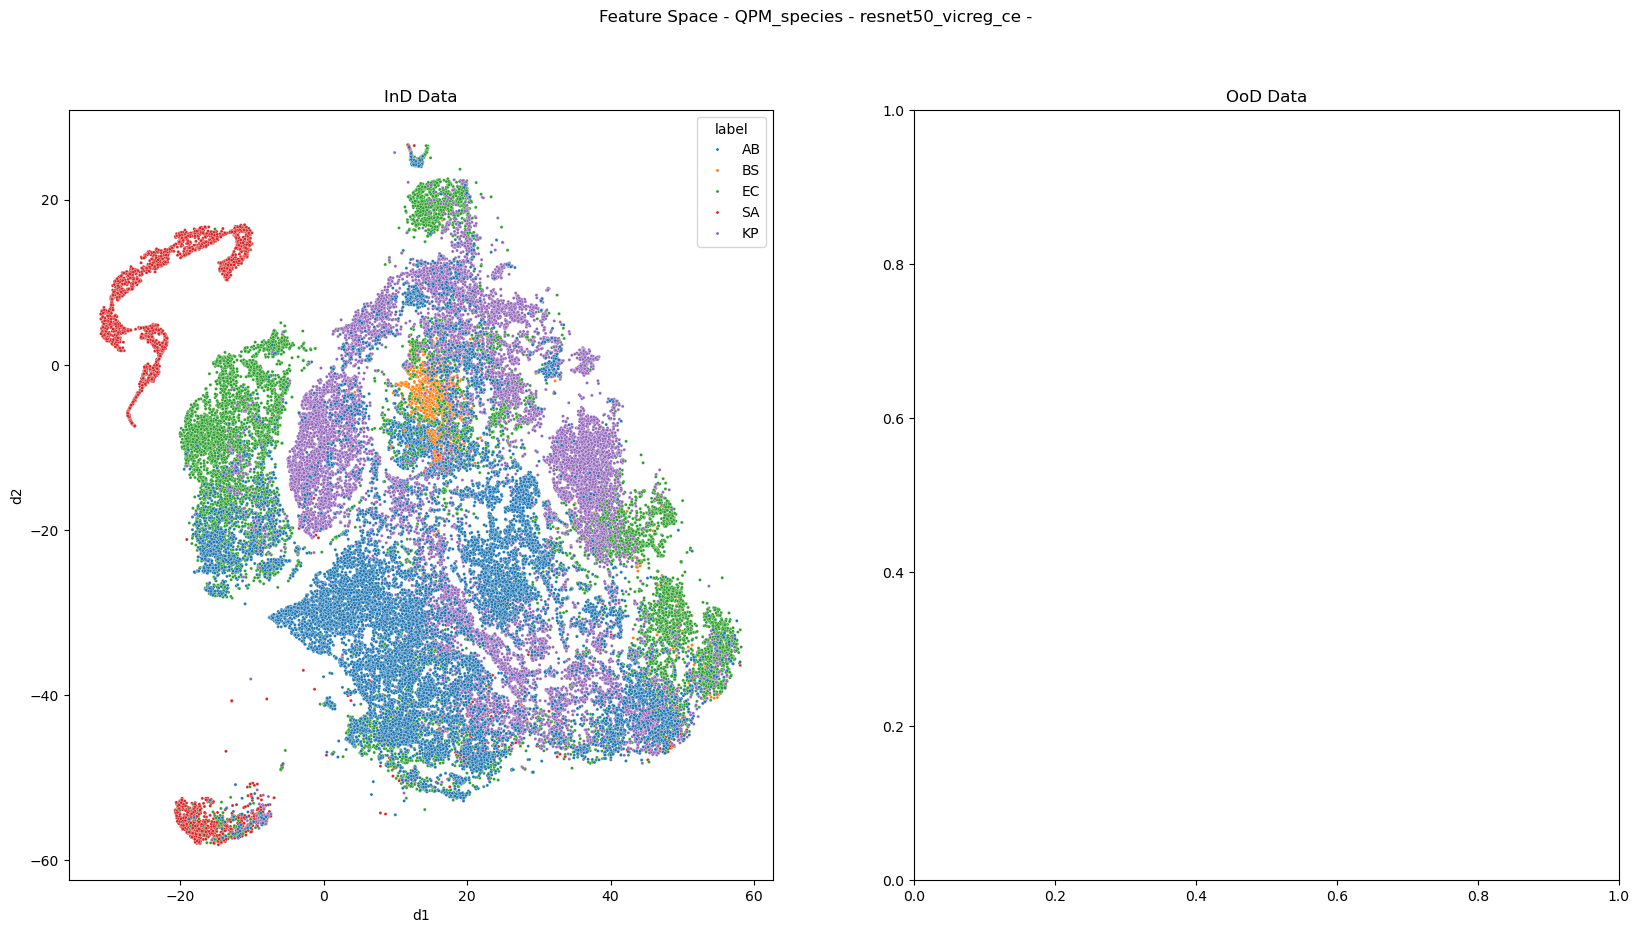

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

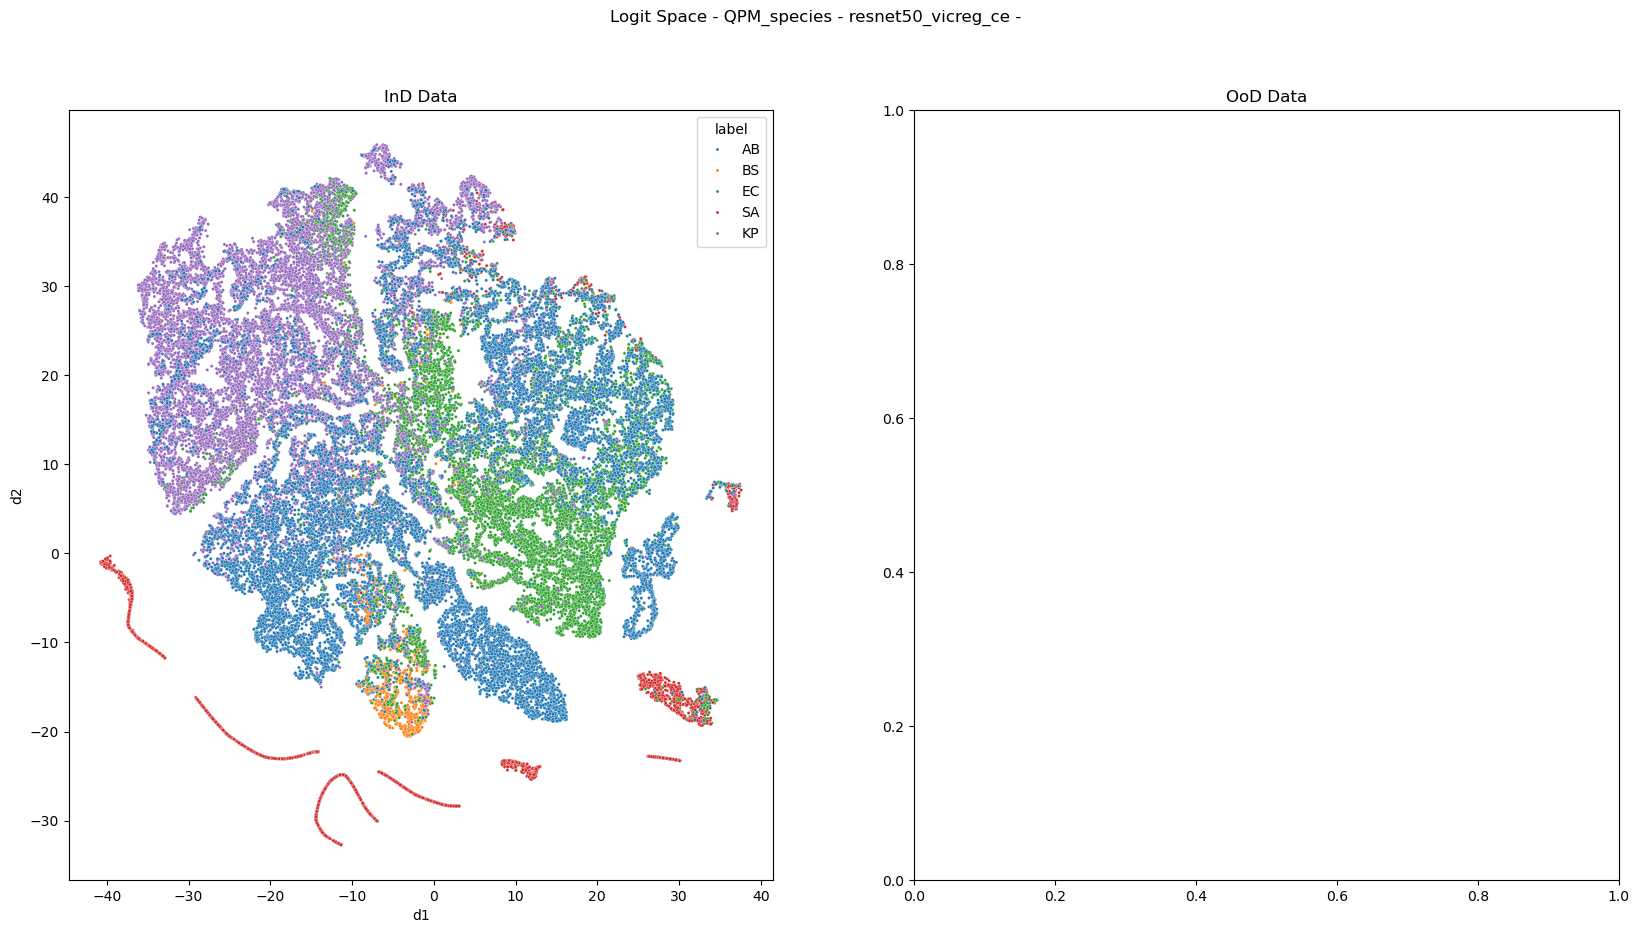

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:54<02:43, 54.37s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [01:50<01:50, 55.14s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [02:45<00:55, 55.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:39<00:00, 54.82s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:39<00:00, 54.87s/it]

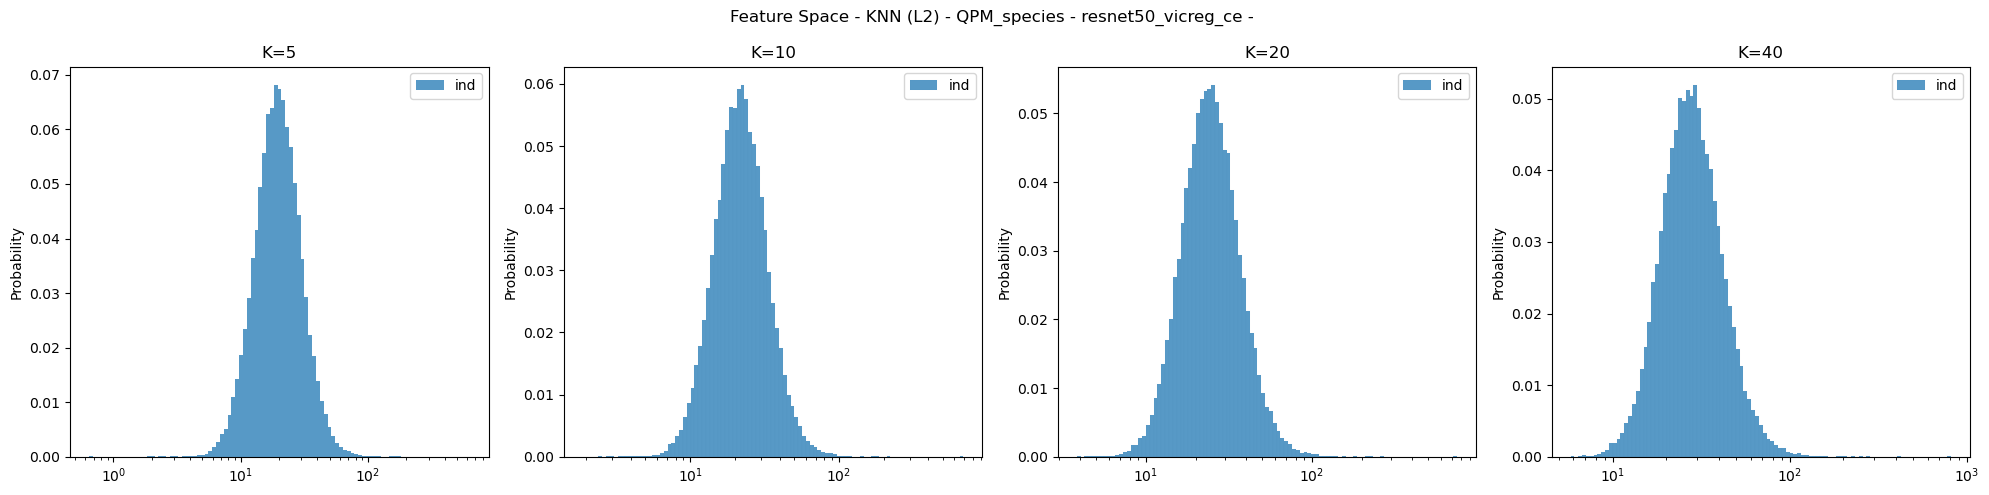

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:53<02:39, 53.16s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [01:46<01:46, 53.22s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [02:40<00:53, 53.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:32<00:00, 52.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:32<00:00, 53.10s/it]

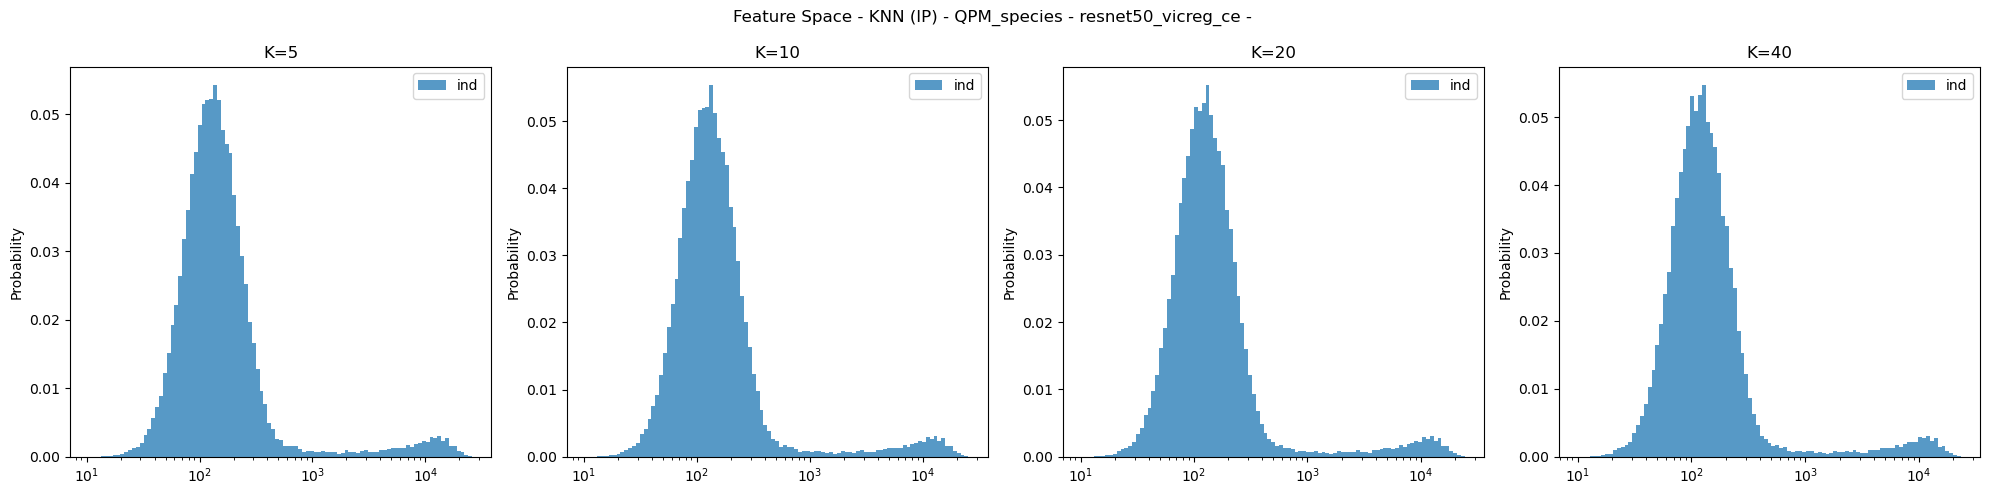

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:53<02:39, 53.14s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [01:46<01:46, 53.21s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [02:39<00:53, 53.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:31<00:00, 52.81s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:31<00:00, 52.97s/it]

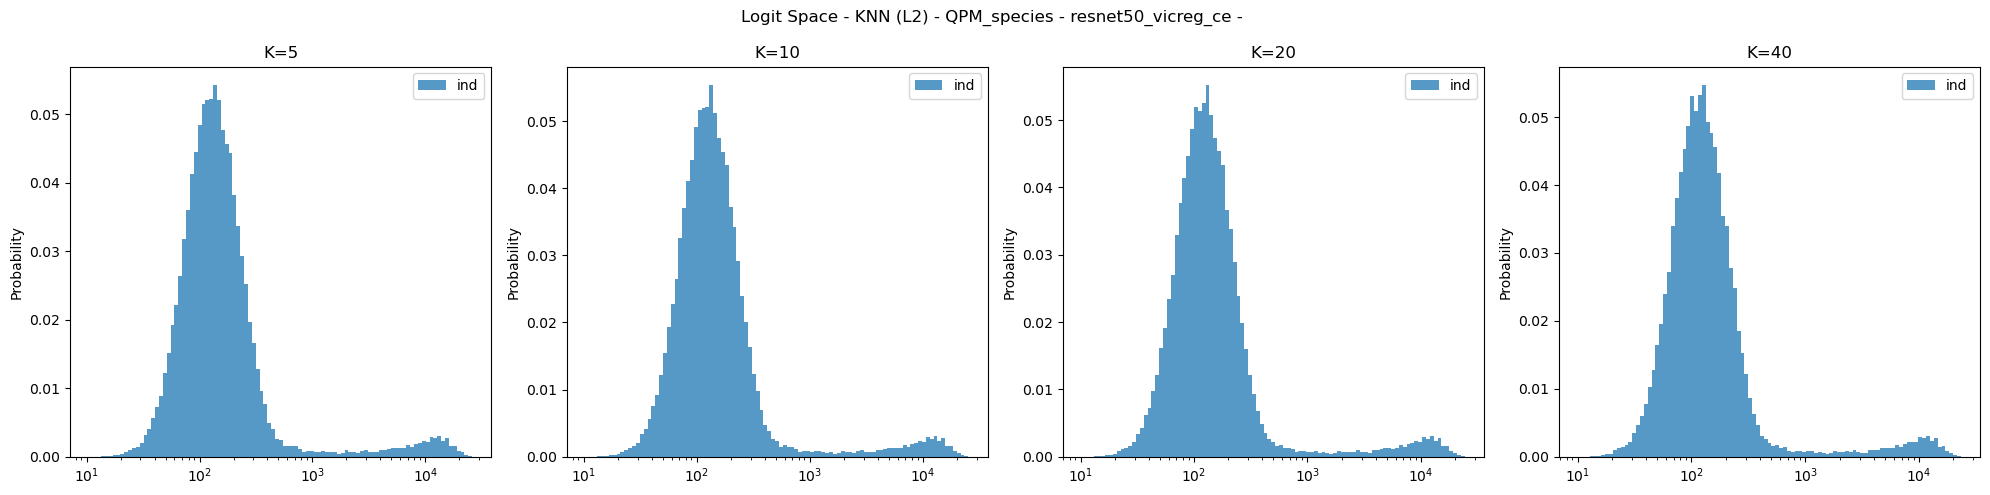

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:53<02:40, 53.34s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [01:46<01:46, 53.33s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [02:40<00:53, 53.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:32<00:00, 52.89s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:32<00:00, 53.07s/it]

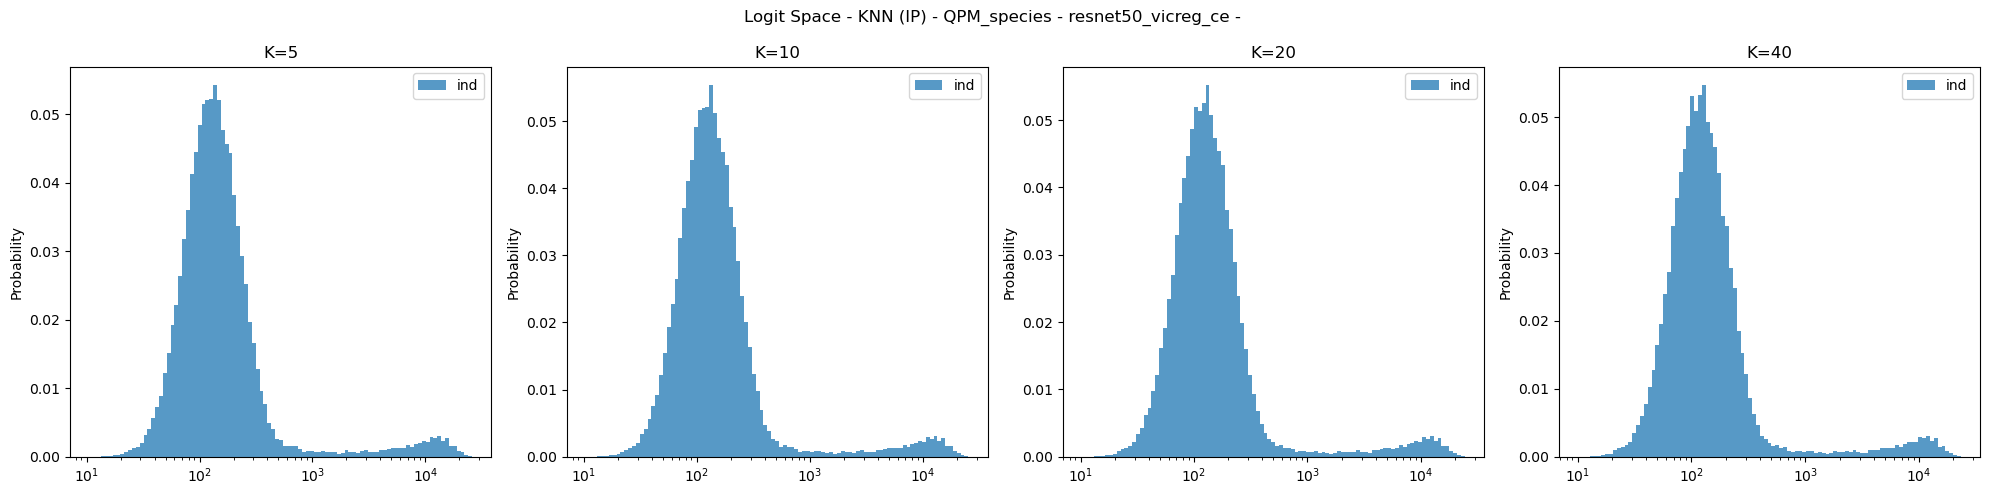

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

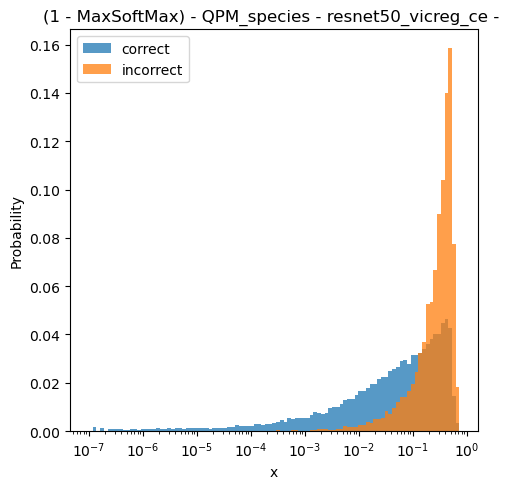

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()